# Identyfikacja Automatów Komórkowych

Wykład: https://github.com/houp/ca-class/blob/main/slides/lecture9.pdf

### Importy

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## zad.16
Zaimplementuj algorytm identyfikacji SCA na podstawie obserwacji. Zaproponuj i zaimplementuj prosty eksperyment, który oceni dokładność identyfikacji.\
W ramach rozwiązania przedstaw wyniki eksperymentu i płynące z nich 
wnioski.

Założenia:
- Obserwacja nie zawiera tzw. "dziur".
- Promień sąsiedztwa z założenia = 1.

Należy zdefiniować miarę dokładności identyfikacji - możesz zastosować jedną z podanych na wykładzie lub zaproponować swoją. Miara ma odpowiadać na 
pytanie jak "blisko" jest zidentyfikowany pLUT od tego, który użyto do wygenerowania obserwacji.\
Eksperyment musi wskazać przynajmniej jeden z czynników wpływających na dokładność identyfikacji. Może to być na przykład: liczba komórek w warunku 
początkowym, liczba kroków czasowych w obserwacji, ogólnie rozmiar obserwacji, liczba elementów w pLUT, które należą do (0,1), średnia odległość
elementów pLUT od $\frac{1}{2}$, liczba zaobserwowanych wystąpień poszczególnych konfiguracji sąsiedztw…

In [2]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)


### Funkcje z zadania 12 (patrz lab6.ipynb)

In [11]:
def sca_evolve(plut: np.ndarray, x: np.ndarray) -> np.ndarray:
    probs = plut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]
    rnd = np.random.random(size=probs.shape)
    return (rnd<probs).astype(np.int8)

def sca_evolve_spacetime(plut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(sca_evolve(plut, rows[-1]))
    return np.stack(rows)

def sca_space_time(spacetime: np.ndarray):
    plt.figure(figsize=(5, 5))
    plt.imshow(spacetime, cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()


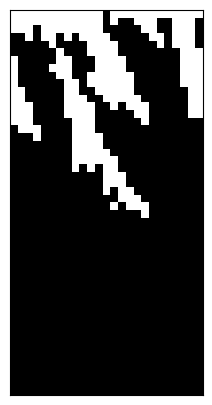

In [12]:
plut = np.array([1, 0.9, 0.75, 0.4, 0.5, 1, 0, 0.2])
spacetime = sca_evolve_spacetime(plut, np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]), 50)
sca_space_time(spacetime)

In [5]:
def plut_from_mixture(probabilities, luts):
    probabilities = np.array(probabilities)
    luts = np.array(luts)
    plut = np.zeros(8)
    for prob, lut in zip(probabilities, luts):
        plut += prob * lut
    return plut

def mixture_from_plut(plut):
    probabilities = []
    luts = []
    pi = np.array([1-plut, plut])
    while np.any(pi > 1e-15):
        L = np.zeros_like(pi)
        max_indices = np.argmax(pi, axis=0)
        L[max_indices, np.arange(pi.shape[1])] = 1
        a = np.min(pi[max_indices, np.arange(pi.shape[1])])
        pi = pi - a*L
        probabilities.append(round(a, 2))
        luts.append(np.array(L[1]))
    return probabilities, luts


In [6]:
luts = [eca_get_lut(170), eca_get_lut(3)]
probabilities = [0.7, 0.3]
print(plut_from_mixture(luts, probabilities))

plut = np.array([1, 0.9, 0.75, 0.4, 0.5, 1, 0, 0.2])
mixture_from_plut(plut)

[0.7 0.  0.7 0.  0.7 0.  1.  0.3]


([0.5, 0.25, 0.15, 0.05, 0.05],
 [array([1., 1., 1., 0., 0., 1., 0., 0.]),
  array([1., 1., 0., 1., 1., 1., 0., 0.]),
  array([1., 1., 1., 1., 1., 1., 0., 1.]),
  array([1., 0., 1., 0., 1., 1., 0., 0.]),
  array([1., 0., 1., 0., 1., 1., 0., 1.])])

### Identyfikacja SCA

In [34]:
def sca_identify(spacetime: np.ndarray, r: int) -> np.ndarray:
    length = 2**(2*r + 1)
    counter = [np.zeros(length), np.zeros(length)]
    # ...
    # nie ma w komórkach wartości -1
    # skaner podobnie jak w ca_identify()
    # tylko teraz zliczamy wystąpienia zer i jedynek
    # jeśli jakieś sąsiedztwo nie wystąpiło, to domyślnie jest 0
    for t in range(spacetime.shape[0] - 1):
        for x in range(spacetime.shape[1]):
            neighborhood = np.array([np.roll(spacetime[t], i)[x] for i in range(r, -r-1, -1)])
            if spacetime[t+1, x] == 0:
                counter[0][length-1 - int(''.join(map(str, neighborhood)), 2)] += 1
            if spacetime[t+1, x] == 1:
                counter[1][length-1 - int(''.join(map(str, neighborhood)), 2)] += 1
    # po zliczeniu obliczamy prawdopodobieństwo otrzymania jedynki
    c = np.sum(counter, axis=0)
    plut = np.array([(counter[1][i]/c[i])for i in range(length)])
    return np.round(plut,2)


In [35]:
plut = np.round(np.random.rand(8),2)
plut

array([0.53, 0.31, 0.23, 0.28, 0.9 , 0.98, 0.49, 0.86])

In [36]:
initial_conf = np.random.randint(0,2,25)
initial_conf

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1])

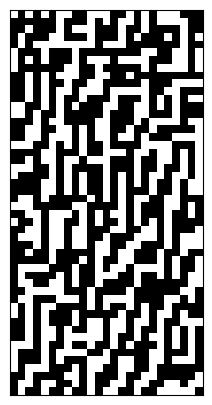

In [37]:
spacetime = sca_evolve_spacetime(plut, initial_conf, 50)
sca_space_time(spacetime)

In [38]:
identified_plut = sca_identify(spacetime, 1)
print(f'Real pLUT: {plut}')
print(f'Identified pLUT: {identified_plut}')

Real pLUT: [0.53 0.31 0.23 0.28 0.9  0.98 0.49 0.86]
Identified pLUT: [0.54 0.37 0.29 0.26 0.87 0.98 0.51 0.81]


### Dokładność identyfikacji

In [39]:
def mean_absolute_error(real_plut, identified_plut):
    return np.mean(np.sum(np.abs(real_plut - identified_plut)))

def maximum_absolute_error(real_plut, identified_plut):
    return np.max(np.abs(real_plut - identified_plut))

def maximum_relative_error(real_plut, identified_plut):
    return np.max(np.abs(real_plut - identified_plut)/real_plut)

def mean_squared_error(real_plut, identified_plut):
    return np.mean(np.sum((real_plut - identified_plut) ** 2))

def root_mean_squared_error(real_plut, identified_plut):
    return np.sqrt(mean_squared_error(real_plut, identified_plut))


In [40]:
print(mean_absolute_error(plut, identified_plut))
print(maximum_absolute_error(plut, identified_plut))
print(maximum_relative_error(plut, identified_plut))
print(mean_squared_error(plut, identified_plut))
print(root_mean_squared_error(plut, identified_plut))

0.24999999999999997
0.06
0.2608695652173912
0.011499999999999993
0.10723805294763605


Wnioski:
- ...
- 

### *Identyfikacja diploidów

In [ ]:
# def sca_identify(spacetime: np.ndarray, r: int) -> np.ndarray:
#     length = 2**(2*r + 1)
#     counter = [np.zeros(length), np.zeros(length)]
#     plut = np.zeros(length)
#     for t in range(spacetime.shape[0] - 1):
#         for x in range(spacetime.shape[1]):
#             neighborhood = np.array([np.roll(spacetime[t], i)[x] for i in range(r, -r-1, -1)])
#             if spacetime[t+1, x] == 0:
            #     counter[0][2**(2*r + 1)-1 - int(''.join(map(str, neighborhood)), 2)] += 1
            # if spacetime[t+1, x] == 1:
            #     counter[1][length-1 - int(''.join(map(str, neighborhood)), 2)] += 1
#     c = np.sum(counter, axis=0)
#     p = [(counter[1][i]/c[i])for i in range(length)]
#     # na tej podstawie ustalamy diploid [f1, f2]
#     diploid = [np.zeros(length), np.zeros(length)]
#     # jeśli p=0: f1=f2=0 (0)
#     # jeśli p=1: f1=f2=1 (1)
#     # jeśli p<0.5: f1=0, f2=1 (1-alfa)
#     # jeśli p>0.5: f1=1, f2=0 (alfa)
#     for prob in p:
#         if prob == 1:
#             diploid[0] += 1
#             diploid[1] += 1
#         if prob < 0.5:
#             diploid[1] += 1
#         if prob >= 0.5: # na razie tak rozstrzygamy przypadek p=0.5
#             diploid[0] += 1
#     # alpha = (czerwone + zielone) / (białe + czarne) tylko dla przypadków prob != 0 i prob != 1
#     # plut = wstawiamy alpha, 1-alpha, 1 i 0
#     return plut
